## 발표자료용 EDA 보충

In [27]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, OrderedDict

import json
from tqdm import tqdm

from transformers import AutoTokenizer

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

## 라벨별 데이터 분포 pie chart 그리기

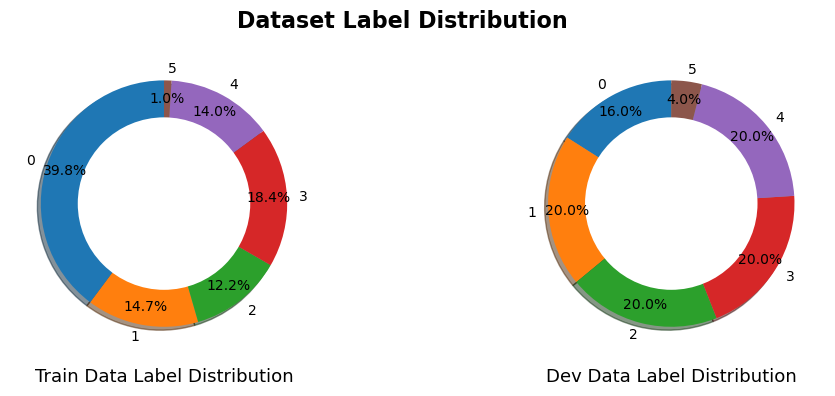

In [88]:
train_data = pd.read_csv("./data/train.csv")
dev_data = pd.read_csv("./data/dev.csv")

train_cp = train_data.copy(deep=True)
dev_cp = dev_data.copy(deep=True)

# label smoothing
def label_smoothing(df):
    df_cp = df.copy(deep=True)
    source_label = {'label': [0, 0, 0, 0, 0, 0]}  
    
    for i, item in df_cp.iterrows():
        label_value = int(item['label'])
        if   label_value == 0:  col = 0
        elif label_value < 2.0: col = 1
        elif label_value < 3.0: col = 2
        elif label_value < 4.0: col = 3
        elif label_value < 5.0: col = 4
        else:                   col = 5
            
        source_label['label'][col] += 1
        source_label_df = pd.DataFrame(source_label)
    return source_label_df

train_label = label_smoothing(train_cp)
dev_label = label_smoothing(dev_cp)

labels = train_label.index.tolist()


fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# train data figure
ax[0].pie(train_label['label'].values.tolist(), labels=labels, startangle=90,
       shadow=True, autopct='%1.1f%%', pctdistance=0.85)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
ax[0].add_artist(centre_circle)

# dev data figure
ax[1].pie(dev_label['label'].values.tolist(), labels=labels, startangle=90,
       shadow=True, autopct='%1.1f%%', pctdistance=0.85)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
ax[1].add_artist(centre_circle)

# title
ax[0].set_xlabel("Train Data Label Distribution", size=13)
ax[1].set_xlabel("Dev Data Label Distribution", size=13)

fig.suptitle("Dataset Label Distribution", size=16, fontweight='bold')

plt.show()

## 전체 데이터세트에 대하여 토큰개수 분포 구하기

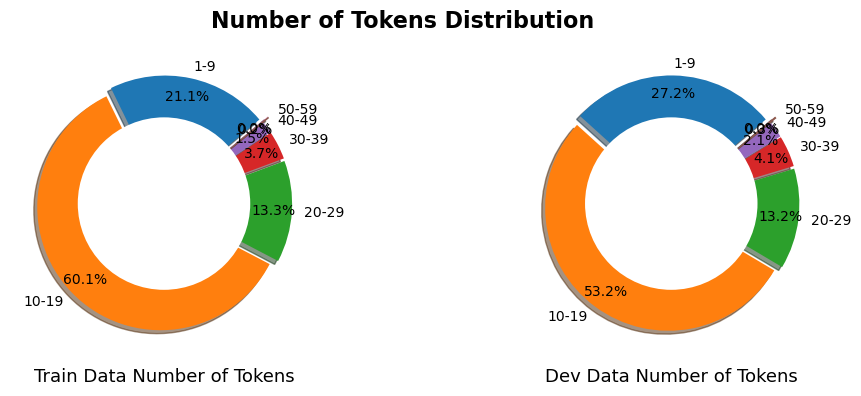

In [90]:
## source, score별로 나누어서 토큰 개수 확인해보기 

# settings
train_cp = train_data.copy(deep=True)
dev_cp = dev_data.copy(deep=True)

tokenizer = AutoTokenizer.from_pretrained('klue/roberta-small')

# 라벨 스무딩
train_label = label_smoothing(train_cp)
dev_label = label_smoothing(dev_cp)

def token_num_smoothing(length):
    if length < 10:         value = 0
    elif length < 20:       value = 1 
    elif length < 30:       value = 2
    elif length < 40:       value = 3
    elif length < 50:       value = 4
    elif length < 60:       value = 5
    else:                   value = 6

    return value        

# 토큰 개수로 새롭게 열 만들기
def get_num_tokens(df):
    sentence1_len, sentence2_len = [], []
    sentence1_unk, sentence2_unk = [], []
    token_num = {'token_1': [0, 0, 0, 0, 0, 0, 0], 'token_2': [0, 0, 0, 0, 0, 0, 0]}    #   0-10, 10-20, 20-30, 40, 50, 60~
    utoken_num = {'utoken_1': [0, 0, 0, 0, 0, 0, 0], 'utoken_2': [0, 0, 0, 0, 0, 0, 0]}
    _index = ["1-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-"]
    
    for i, item in df.iterrows():
        sentence1 = tokenizer(item['sentence_1'])['input_ids']
        sentence2 = tokenizer(item['sentence_2'])['input_ids']

        # smoothing
        tn1, tn2 = token_num_smoothing(len(sentence1)), token_num_smoothing(len(sentence2))
        
        # token num count
        token_num['token_1'][tn1] += 1
        token_num['token_2'][tn2] += 1
        
        # unk token num count
        utoken_num['utoken_1'][tn1] += sentence1.count(tokenizer.unk_token_id)
        utoken_num['utoken_2'][tn2] += sentence2.count(tokenizer.unk_token_id)

    token_df, utoken_df = pd.DataFrame(token_num, index=_index), pd.DataFrame(utoken_num, index=_index)
    token_df = pd.concat([token_df, utoken_df], axis=1)
    return token_df

train_token_df = get_num_tokens(train_cp)
dev_token_df = get_num_tokens(dev_cp)

train_token_df['token_total'] = [i+j for i,j in zip(train_token_df['token_1'].values.tolist(), train_token_df['token_2'].values.tolist())]
dev_token_df['token_total'] = [i+j for i,j in zip(dev_token_df['token_1'].values.tolist(), dev_token_df['token_2'].values.tolist())]


# figure tokens numbers into pie chart
labels = train_token_df.index.values.tolist()
labels[-1] = ""

train_token_x = train_token_df['token_total']
dev_token_x = dev_token_df['token_total']


fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# explode
explode = [0.04, 0.04, 0.04, 0.04, 0.04, 0.1, 0.1]
# train figure
ax[0].pie(train_token_x, labels=labels, startangle=40,
       shadow=True, autopct='%1.1f%%', pctdistance=0.85, explode=explode)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
ax[0].add_artist(centre_circle)

# dev figure
ax[1].pie(dev_token_x, labels=labels, startangle=40,
       shadow=True, autopct='%1.1f%%', pctdistance=0.85, explode=explode)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
ax[1].add_artist(centre_circle)

# title
ax[0].set_xlabel("Train Data Number of Tokens", size=13)
ax[1].set_xlabel("Dev Data Number of Tokens", size=13)

fig.suptitle("Number of Tokens Distribution", size=16, fontweight='bold', ha='center')

plt.show()


## 토큰개수 한번에 확인하기

In [91]:
## source, score별로 나누어서 토큰 개수 확인해보기 

# settings
from collections import Counter, OrderedDict

train_path = './data/train.csv'
dev_path = './data/dev.csv'

train_data = pd.read_csv(train_path)
dev_data = pd.read_csv(dev_path)

tokenizer = AutoTokenizer.from_pretrained('klue/roberta-small')

# Function Settings
def get_num_tokens(df):
    sentence1_len, sentence2_len = [], []
    sentence1_unk, sentence2_unk = [], []
    
    for i, item in df.iterrows():
        sentence1 = tokenizer(item['sentence_1'])['input_ids']
        sentence2 = tokenizer(item['sentence_2'])['input_ids']

        sentence1_len.append(len(sentence1))
        sentence2_len.append(len(sentence2))

        sentence1_unk.append(sentence1.count(tokenizer.unk_token_id))
        sentence2_unk.append(sentence2.count(tokenizer.unk_token_id))

    return sentence1_len, sentence2_len, sentence1_unk, sentence2_unk
    # return pd.DataFrame({'number of tokens':sentence1_len, 'label score':df.label.values.tolist()})


# 1. 전체 df에 대해 score 5단계로 분류, 열 추가
train_data_scored = train_data.copy(deep=True)
score_integer = []

for i, item in train_data_scored.iterrows():
    label_value = int(item['label'])
    if   label_value == 0:  col = 0
    elif label_value < 2.0: col = 1
    elif label_value < 3.0: col = 2
    elif label_value < 4.0: col = 3
    elif label_value < 5.0: col = 4
    else:                   col = 5
        
    score_integer.append(col)
train_data_scored['score_class'] = score_integer

# 2. sentence 별 토큰 개수 넣기
s1_len, s2_len, s1_unk, s2_unk = get_num_tokens(train_data_scored)

train_data_scored['s1_num_tokens'] = s1_len
train_data_scored['s2_num_tokens'] = s2_len
train_data_scored['s1_num_unk'] = s1_unk
train_data_scored['s2_num_unk'] = s2_unk



In [110]:
train_data_scored[train_data_scored['s1_num_tokens'] > 50]

,id,source,sentence_1,sentence_2,label,binary-label,score_class,s1_num_tokens,s2_num_tokens,s1_num_unk,s2_num_unk,token1_sm
226,boostcamp-sts-v1-train-226,nsmc-rtt,"그런거 보면,배우란,해내면,참 좋은 직업갖기도 하고,실제 현장에서,고생하는거 보면,...","그러고 보니 배우가 할 수만 있다면 정말 좋은 직업을 가질 때도 있고, 현실에서 열...",2.8,1.0,2,57,42,0,0,5
996,boostcamp-sts-v1-train-996,petition-rtt,이명박 출국금지 구속수사!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,이명박 출국금지 구속 수사!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,5.0,1.0,5,88,84,0,0,6
1042,boostcamp-sts-v1-train-1042,slack-sampled,"제가 입사할 때 면접에서 뵙고 처음 뵙는건데, 공교롭게도 제가 처음으로 면접에 들어...","작년 입사일에 온보딩으로 뵙고는 처음으로 인사를 드렸는데, 그때의 기억이 새록새록 ...",1.4,0.0,1,54,32,0,0,5
1148,boostcamp-sts-v1-train-1148,nsmc-rtt,평점에낚엿어...........................................,시청률에 낚였습니다.......................................,1.4,0.0,1,54,79,0,0,5
2412,boostcamp-sts-v1-train-2412,nsmc-rtt,‥ 김민희를알수록 의심되는 정체. 완벽한연기. 완벽한몰입과스릴. 작은반전. 무엇보다...,‥ 김민희를 알면 알수록 의심스러워진다. 완벽한 연기. 완벽한 몰입과 스릴. 작은 ...,4.0,1.0,4,60,61,0,0,6
2517,boostcamp-sts-v1-train-2517,nsmc-rtt,"어딘가 우울하고, 지저분하고, 하지만 어딘가 우리의 삶이 보이는것 같기도 하고. '...",다소 암울하고 어수선하지만 어딘지 모르게 우리의 삶이 어딘가에 보이는 것 같다. '...,3.4,1.0,3,55,53,0,0,5
2533,boostcamp-sts-v1-train-2533,nsmc-rtt,평점을낮게 깍는분들중에는 단순한 재미가있냐 없냐만으로 평점을 정하시는분들이 많은데 ...,등급을 낮추는 사람들 중에는 단순히 재미가 있느냐 없느냐로 평가를 결정하는 사람이 ...,3.6,1.0,3,61,53,0,0,6
3521,boostcamp-sts-v1-train-3521,nsmc-rtt,같은 남자가 봐도 어처구니 없을 정도로 잘생긴 세기의 미남 배우도 맞춤 옷을 입은 ...,같은 남자라도 믿을 수 없을 정도로 잘생긴 세기의 미남 배우라도 맞춤 양복을 입은 ...,4.2,1.0,4,51,50,0,0,5
3642,boostcamp-sts-v1-train-3642,nsmc-rtt,일제와 분단때문에 생겨난 일본의 조총련이라는 동포들은 한국의 지원도 받지못하고 소외...,일제강점기와 분단으로 탄생한 조총련이라는 조선동포들은 조선의 지원을 받지 못하고 소...,3.8,1.0,3,52,52,0,0,5
3696,boostcamp-sts-v1-train-3696,slack-sampled,"기존 회사에서 2번과 같이 써왔어서 익숙해서 그냥 그렇게 쓰고는 있는데, 이렇게 쓸...","네네. 저도 처음에는 뭔가 괴상한 한글 같아서 거부감이 있었는데, 그것도 쓰다보니 ...",0.0,0.0,0,52,36,0,0,5


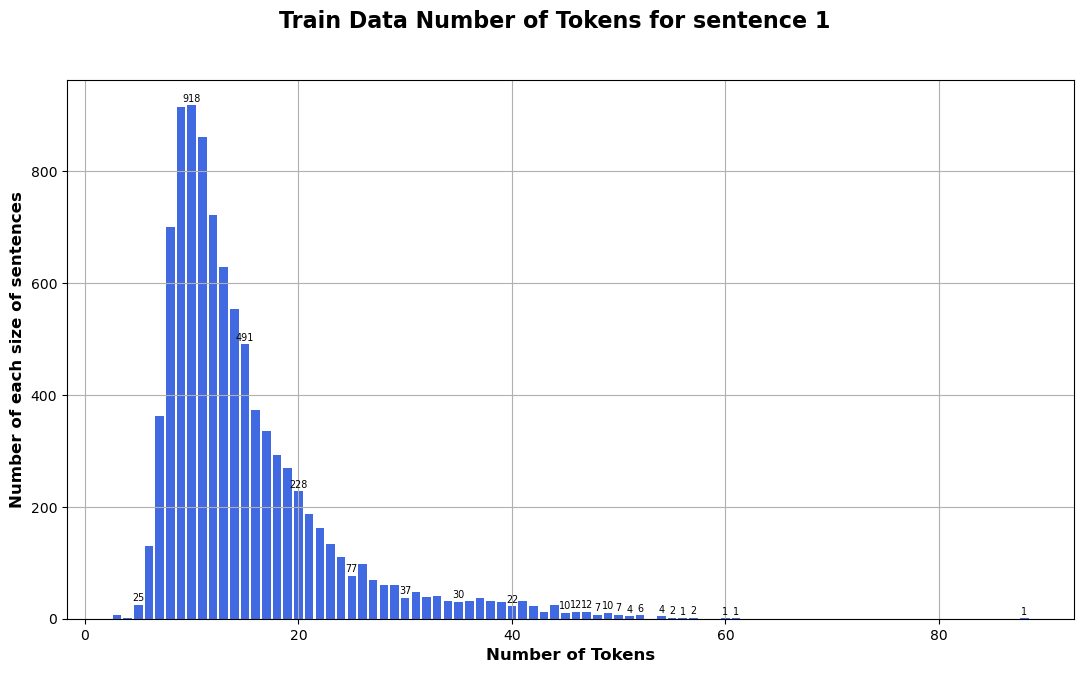

In [108]:
## 토큰 개수 스무딩
token1_sm = []

for i, item in train_data_scored.iterrows():
    token_number_1 = token_num_smoothing(item['s1_num_tokens'])
    token1_sm.append(token_number_1)
    
train_data_scored['token1_sm'] = token1_sm

group = train_data_scored.groupby("score_class")['s1_num_tokens']
group.value_counts().sort_index()



s1_counted   = OrderedDict(Counter(sorted(train_data_scored['s1_num_tokens'].values.tolist())))
s2_counted   = OrderedDict(Counter(sorted(train_data_scored['s2_num_tokens'].values.tolist())))
# unk token numbers
unk1_locations = train_data_scored[train_data_scored['s1_num_unk'] > 0]
unk1_counted = OrderedDict(Counter(sorted(train_data_scored['s1_num_unk'].values.tolist())))
unk2_counted = OrderedDict(Counter(sorted(train_data_scored['s2_num_unk'].values.tolist())))

s1_x, s1_y = s1_counted.keys(),   s1_counted.values()
s2_x, s2_y = s2_counted.keys(),   s2_counted.values()

fig, axes = plt.subplots(1, 1, 
                            figsize=(13, 7), 
                            sharey=True, 
                            sharex=True
                            )

axes.bar(s1_x, s1_y, color='royalblue')
axes.grid(zorder=0)
#axes[score].bar(u1_x, u1_y, bottom=list(s1_y)[:len(u1_x)], color='tomato')
#print(f"unk value: {score}, x: {u1_x}, y: {u1_y}")

upper_20_value = pd.Series(s1_x).quantile(0.75)
for idx, value in zip(s1_x, s1_y):
    if idx % 5 != 0 and idx < upper_20_value:
        continue
    
    axes.text(idx, value+7, s=value, ha='center', fontsize='x-small')
    axes.set_ylabel(f'Number of each size of sentences', fontsize=12, weight='bold')
    
#axes[score].set_ylim(0, 150)

fig.suptitle(f"Train Data Number of Tokens for sentence 1", fontsize=16, fontweight='bold')
axes.set_xlabel('Number of Tokens', fontsize=12, weight='bold')
#axes.set_ylabel('number of each size of sentences', fontsize=12)


# fig.text(0.5, 0.04, 'number of tokens', ha='center', fontsize=12, fontweight='bold')
# fig.text(0.055, 0.5, 'number of each size of sentences', va='center', rotation='vertical', fontsize=12, fontweight='bold')

#axes[5].set_ylim(0, 5)
plt.show()

